## Add Features to exgo

In [2]:
import pandas as pd

df = pd.read_csv("df_daily_modified.csv")  # Or your actual
df = df.drop(columns=["MT_178"])
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

# Extract client columns (assuming they start with "MT_")
client_columns = [col for col in df.columns if col.startswith("MT_")]

# Create the series_dict with trimmed leading zeros
series_dict = {}
for col in client_columns:
    series = df[col]

    # Find the first non-zero index
    first_non_zero_idx = series.ne(0).idxmax()

    # Trim the series
    trimmed_series = series.loc[first_non_zero_idx:]

    # Store in the dictionary
    series_dict[col] = trimmed_series

In [3]:
import numpy as np
import pandas as pd

# Assume series_dict is already defined
# Each key is a client ID (e.g., 'MT_001') and value is a pandas Series with datetime index

exog_dict = {}

for client_id, series in series_dict.items():
    date_index = series.index

    # Day of week (0 = Monday, 6 = Sunday)
    day_of_week = date_index.dayofweek
    sin_dow = np.sin(2 * np.pi * day_of_week / 7)
    cos_dow = np.cos(2 * np.pi * day_of_week / 7)

    # Day of year (1 to 365/366)
    day_of_year = date_index.dayofyear
    sin_doy = np.sin(2 * np.pi * day_of_year / 365)
    cos_doy = np.cos(2 * np.pi * day_of_year / 365)

    # Create DataFrame of cyclical features
    exog_df = pd.DataFrame({
        'sin_dow': sin_dow,
        'cos_dow': cos_dow,
        'sin_doy': sin_doy,
        'cos_doy': cos_doy
    }, index=date_index)

    # Store in dictionary
    exog_dict[client_id] = exog_df


In [4]:
# Assume avg_temp_df is a DataFrame with 'timestamp' and 'avg_temp' columns
avg_temp_df = pd.read_csv("avgtemp_only.csv", parse_dates=["timestamp"])
avg_temp_df = avg_temp_df.set_index("timestamp")

# Ensure it has the same frequency as series_dict
avg_temp_df = avg_temp_df.asfreq("D").fillna(method="ffill")  # Fill missing values

<ipython-input-4-597b0f182484>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  avg_temp_df = avg_temp_df.asfreq("D").fillna(method="ffill")  # Fill missing values


In [5]:
for client_id in exog_dict.keys():
    # Add average temperature
    exog_dict[client_id]["avg_temp"] = avg_temp_df["avgtempC"]

In [6]:
cluster_df = pd.read_csv("client_clusters.csv")

# Iterate over all clients
for client_id in series_dict.keys():

    # Get existing exog_df
    if client_id in exog_dict:
        exog_df = exog_dict[client_id]
    else:
        # If no exog_df exists, initialize one with the same index as the time series
        exog_df = pd.DataFrame(index=series_dict[client_id].index)

    # Add cluster information if the client exists in cluster_df
    if client_id in cluster_df["Client"].values:
        cluster_label = cluster_df.loc[cluster_df["Client"] == client_id, "Cluster"].values[0]
        # Assign cluster using index alignment to preserve timestamps
        exog_df["Cluster"] = cluster_label

    # Update the dictionary (now just updating, not overwriting other features)
    exog_dict[client_id]["Cluster"] = exog_df["Cluster"]


In [38]:
exog_dict

{'MT_001':              sin_dow   cos_dow       sin_doy   cos_doy  avg_temp  Cluster
 timestamp                                                                
 2012-01-01 -0.781831  0.623490  1.721336e-02  0.999852      12.0        0
 2012-01-02  0.000000  1.000000  3.442161e-02  0.999407      13.0        0
 2012-01-03  0.781831  0.623490  5.161967e-02  0.998667      10.5        0
 2012-01-04  0.974928 -0.222521  6.880243e-02  0.997630      13.5        0
 2012-01-05  0.433884 -0.900969  8.596480e-02  0.996298      12.5        0
 ...              ...       ...           ...       ...       ...      ...
 2014-12-28 -0.781831  0.623490 -5.161967e-02  0.998667      13.0        0
 2014-12-29  0.000000  1.000000 -3.442161e-02  0.999407       9.0        0
 2014-12-30  0.781831  0.623490 -1.721336e-02  0.999852       8.0        0
 2014-12-31  0.974928 -0.222521  6.432491e-16  1.000000       8.5        0
 2015-01-01  0.433884 -0.900969  1.721336e-02  0.999852      11.0        0
 
 [1097 rows x

## Split Train-Test

In [7]:
split_date = pd.Timestamp("2014-08-01")

series_dict_train = {}
series_dict_test = {}
exog_dict_train = {}
exog_dict_test = {}

for client_id, series in series_dict.items():
    # Ensure DatetimeIndex
    series.index = pd.to_datetime(series.index)
    series = series.sort_index()  # Ensure chronological order

    # Split by date
    series_train = series.loc[series.index < split_date]
    series_test = series.loc[series.index >= split_date]

    # Set frequency (daily)
    series_train = series_train.asfreq('D')
    series_test = series_test.asfreq('D')

    series_dict_train[client_id] = series_train
    series_dict_test[client_id] = series_test

    # Handle exogenous features
    if client_id in exog_dict:
        exog_series = exog_dict[client_id]
        exog_series.index = pd.to_datetime(exog_series.index)
        exog_series = exog_series.sort_index()

        # Train/test split using date
        exog_train = exog_series.loc[exog_series.index < split_date]
        exog_test_raw = exog_series.loc[exog_series.index >= split_date]

        # Set frequency on training
        exog_train = exog_train.asfreq('D')

        # Reindex exog_test to future dates for prediction
        last_train_date = series_train.index[-1]
        forecast_steps = len(series_test)
        future_index = pd.date_range(start=last_train_date + pd.Timedelta(days=1),
                                     periods=forecast_steps, freq='D')
        exog_test = exog_test_raw.copy()
        exog_test.index = future_index
        exog_test = exog_test.asfreq('D')

        # Final checks
        assert isinstance(exog_train.index, pd.DatetimeIndex)
        assert isinstance(exog_test.index, pd.DatetimeIndex)
        assert exog_train.index.freq is not None
        assert exog_test.index.freq is not None

        exog_dict_train[client_id] = exog_train
        exog_dict_test[client_id] = exog_test


In [51]:
series_dict_test['MT_177']

,MT_177
timestamp,
2014-08-01,4187.979042
2014-08-02,4128.173653
2014-08-03,4201.403443
2014-08-04,4026.781437
2014-08-05,4196.223802
...,...
2014-12-28,3389.509731
2014-12-29,3303.334581
2014-12-30,3534.330090


In [8]:
!pip install skforecast


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.5 MB/s eta 0:00:00


## Train & predict

In [9]:
!pip install pytorch-forecasting --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import RecurrentNetwork
from pytorch_forecasting.metrics import SMAPE
from lightning.pytorch import Trainer


In [11]:
import pandas as pd

df_list = []

for level, series in series_dict_train.items():
    # Get corresponding exogenous DataFrame
    exog = exog_dict_train[level].copy()

    temp_df = pd.DataFrame({
        "time_idx": range(len(series)),
        "target": series.values,
        "group_id": level
    })

    # Add timestamp to align with exogenous features
    temp_df["time"] = series.index
    exog["time"] = exog.index
    exog["group_id"] = level

    # Merge target series with exogenous features
    merged_df = pd.merge(temp_df, exog, on=["time", "group_id"])

    df_list.append(merged_df)

# Combine all groups
df_train = pd.concat(df_list).reset_index(drop=True)

# Optional: make sure group_id is categorical
df_train["group_id"] = df_train["group_id"].astype("category")

df_train.head()


,time_idx,target,group_id,time,sin_dow,cos_dow,sin_doy,cos_doy,avg_temp,Cluster
0,0,177.982234,MT_001,2012-01-01,-0.781831,0.623490,0.017213,0.999852,12.0,0
1,1,256.345178,MT_001,2012-01-02,0.000000,1.000000,0.034422,0.999407,13.0,0
2,2,260.152284,MT_001,2012-01-03,0.781831,0.623490,0.051620,0.998667,10.5,0
3,3,273.477157,MT_001,2012-01-04,0.974928,-0.222521,0.068802,0.997630,13.5,0
4,4,337.880711,MT_001,2012-01-05,0.433884,-0.900969,0.085965,0.996298,12.5,0


In [12]:
from pytorch_forecasting import TimeSeriesDataSet, RecurrentNetwork
from pytorch_forecasting.metrics import SMAPE
from lightning.pytorch import Trainer
import torch

max_encoder_length = 30
max_prediction_length = 24

training = TimeSeriesDataSet(
    df_train,  # this should include all time series + exog columns
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,

    # 👇 now we explicitly tell it these are the known inputs at each time step
    time_varying_known_reals=[
        "time_idx", "sin_dow", "cos_dow", "sin_doy", "cos_doy", "avg_temp", "Cluster"
    ],

    time_varying_unknown_reals=["target"],
    static_categoricals=["group_id"],
)

# Create dataloader
train_dataloader = training.to_dataloader(train=True, batch_size=64)
val_dataloader = training.to_dataloader(train=False, batch_size=64)

# Define the LSTM model (RecurrentNetwork)
lstm = RecurrentNetwork.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    cell_type="LSTM",
    dropout=0.1,
    loss=SMAPE(),
)

# Optional: see number of parameters
print(f"Total parameters: {sum(p.numel() for p in lstm.parameters())}")

# Train the model
trainer = Trainer(max_epochs=10, gradient_clip_val=0.1)
trainer.fit(
    lstm,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/encoders.py:631: RuntimeWarning: overflow encountered in cast
  self.scale_ = np.std(y_scale) + eps
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading

Total parameters: 22909


INFO: 
  | Name             | Type           | Params | Mode 
------------------------------------------------------------
0 | loss             | SMAPE          | 0      | train
1 | logging_metrics  | ModuleList     | 0      | train
2 | embeddings       | MultiEmbedding | 16.2 K | train
3 | rnn              | LSTM           | 6.7 K  | train
4 | output_projector | Linear         | 17     | train
------------------------------------------------------------
22.9 K    Trainable params
0         Non-trainable params
22.9 K    Total params
0.092     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name             | Type           | Params | Mode 
------------------------------------------------------------
0 | loss             | SMAPE          | 0      | train
1 | logging_metrics  | ModuleList     | 0      | train
2 | embeddings       | MultiEmbedding | 16.2 K | train
3 | rnn            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
df_test_list = []
for level, series in series_dict_test.items():
    temp_df = pd.DataFrame({
        "time": series.index,  # keep original timestamps for later
        "time_idx": range(len(series)),  # will be aligned later
        "target": series.values,
        "group_id": level
    })
    df_test_list.append(temp_df)

df_test = pd.concat(df_test_list).reset_index(drop=True)


exog_test_list = []
for level, df in exog_dict_test.items():
    temp_exog = df.copy()
    temp_exog["time"] = df.index
    temp_exog["group_id"] = level
    exog_test_list.append(temp_exog)

df_exog_test = pd.concat(exog_test_list).reset_index(drop=True)


df_test_full = pd.merge(df_test, df_exog_test, on=["group_id", "time"])


test_dataset = TimeSeriesDataSet(
    df_test_full,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["target"],
    time_varying_known_reals=["time_idx", "sin_dow", "cos_dow", "sin_doy", "cos_doy", "avg_temp", "Cluster"],
    static_categoricals=["group_id"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=64)
test_dataset

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/encoders.py:631: RuntimeWarning: overflow encountered in cast
  self.scale_ = np.std(y_scale) + eps


TimeSeriesDataSet[length=37269](
	time_idx='time_idx',
	target='target',
	group_ids=['group_id'],
	weight=None,
	max_encoder_length=30,
	min_encoder_length=30,
	min_prediction_idx=0,
	min_prediction_length=24,
	max_prediction_length=24,
	static_categoricals=['group_id'],
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['time_idx', 'sin_dow', 'cos_dow', 'sin_doy', 'cos_doy', 'avg_temp', 'Cluster'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=['target'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_id': NaNLabelEncoder(add_nan=False, warn=True), 'group_id': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': 

In [88]:
print(y_pred_final.shape)


torch.Size([369, 24])


In [14]:
print(training.reals)
print(training.categoricals)

['time_idx', 'sin_dow', 'cos_dow', 'sin_doy', 'cos_doy', 'avg_temp', 'Cluster', 'target']
['group_id']


In [15]:
predictions = lstm.predict(test_dataloader, return_x=True)


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [76]:
# # Total number of predictions made
# total_preds = predictions.output.shape[0]  # 37269
# # Number of clients (groups)
# n_groups = 369
# # Prediction length (per sample)
# pred_len = 24
# # Number of windows per group
# num_windows = total_preds // n_groups  # Might be 101 here

# # Reshape to [group, window, pred_len]
# y_pred_all = predictions.output.view(n_groups, num_windows, pred_len)

# # Take only the last window per group
# y_pred_final = y_pred_all[:, -1, :]  # shape should be [369, 24]


In [93]:
n_groups = 369
y_pred_all = predictions.output.view(n_groups, -1, max_prediction_length)
y_pred_final = y_pred_all[:, -1, :]  # shape = [369, 24]
y_pred_final

tensor([[4.9417e+01, 4.8593e+01, 4.9012e+01,  ..., 5.0982e+01, 5.1024e+01,
         5.5852e+01],
        [5.5349e+02, 5.5571e+02, 5.5668e+02,  ..., 5.5946e+02, 5.5947e+02,
         5.5948e+02],
        [4.0822e+01, 4.0883e+01, 4.0894e+01,  ..., 4.0720e+01, 4.0901e+01,
         4.0904e+01],
        ...,
        [3.4715e+03, 3.6160e+03, 3.5757e+03,  ..., 3.5864e+03, 3.6309e+03,
         3.5224e+03],
        [1.8097e+04, 1.8371e+04, 1.8293e+04,  ..., 1.9273e+04, 1.9431e+04,
         1.9090e+04],
        [4.3219e+05, 4.2302e+05, 4.2067e+05,  ..., 4.1473e+05, 4.1907e+05,
         4.1921e+05]])

In [101]:
y_true

tensor([[3.8135e+02, 3.9943e+02, 4.1720e+02,  ..., 3.9372e+02, 3.9657e+02,
         3.9181e+02],
        [7.8005e+02, 7.6885e+02, 7.8289e+02,  ..., 7.9659e+02, 7.9516e+02,
         7.9801e+02],
        [4.0834e+01, 4.4309e+01, 3.7793e+01,  ..., 4.0834e+01, 4.4309e+01,
         3.7793e+01],
        ...,
        [3.6486e+03, 1.4729e+03, 1.2216e+03,  ..., 3.6448e+03, 1.3927e+03,
         1.1532e+03],
        [2.2380e+04, 2.1008e+04, 1.8764e+04,  ..., 2.3073e+04, 2.1063e+04,
         1.9066e+04],
        [4.6542e+05, 5.1158e+05, 5.0718e+05,  ..., 5.4572e+05, 5.4392e+05,
         5.3008e+05]])

In [113]:
import torch

# Sort and get first 24 rows per group
df_sorted = df_test_full.sort_values(by=["group_id", "time_idx"])
df_first_24 = df_sorted.groupby("group_id").head(24)

# Extract and convert to tensor
y_true = torch.tensor(df_first_24["target"].values, dtype=torch.float)

# Reshape to match y_pred
y_true = y_true.reshape(-1, 24)


In [90]:


# Then metrics
assert y_pred_final.shape == y_true.shape

In [96]:
from pytorch_forecasting.metrics import MAPE

mape = MAPE()

# Flatten both tensors
y_pred_flat = y_pred_final.flatten()
y_true_flat = y_true.flatten()

# Create mask
mask = y_true_flat != 0

# Compute MAPE
# Manually compute MAPE while avoiding division by zero
mape_score = ((y_true_flat[mask] - y_pred_flat[mask]).abs() / y_true_flat[mask].abs()).mean() * 100
print(f"MAPE (excluding zeros): {mape_score:.2f}%")


MAPE (excluding zeros): 135.94%


In [109]:
print("Min of y_true:", y_true.min())
print("Any zeros in y_true?", (y_true == 0).sum())

Min of y_true: 2428.3538
Any zeros in y_true? 0


In [110]:
print(predictions.output.shape)  # should be [n_groups, prediction_length]
print(y_true.shape)

torch.Size([37269, 24])
(24,)


In [116]:
print(predictions.output.shape)  # Find the real shape
print(predictions.output.numel())

torch.Size([37269, 24])
894456


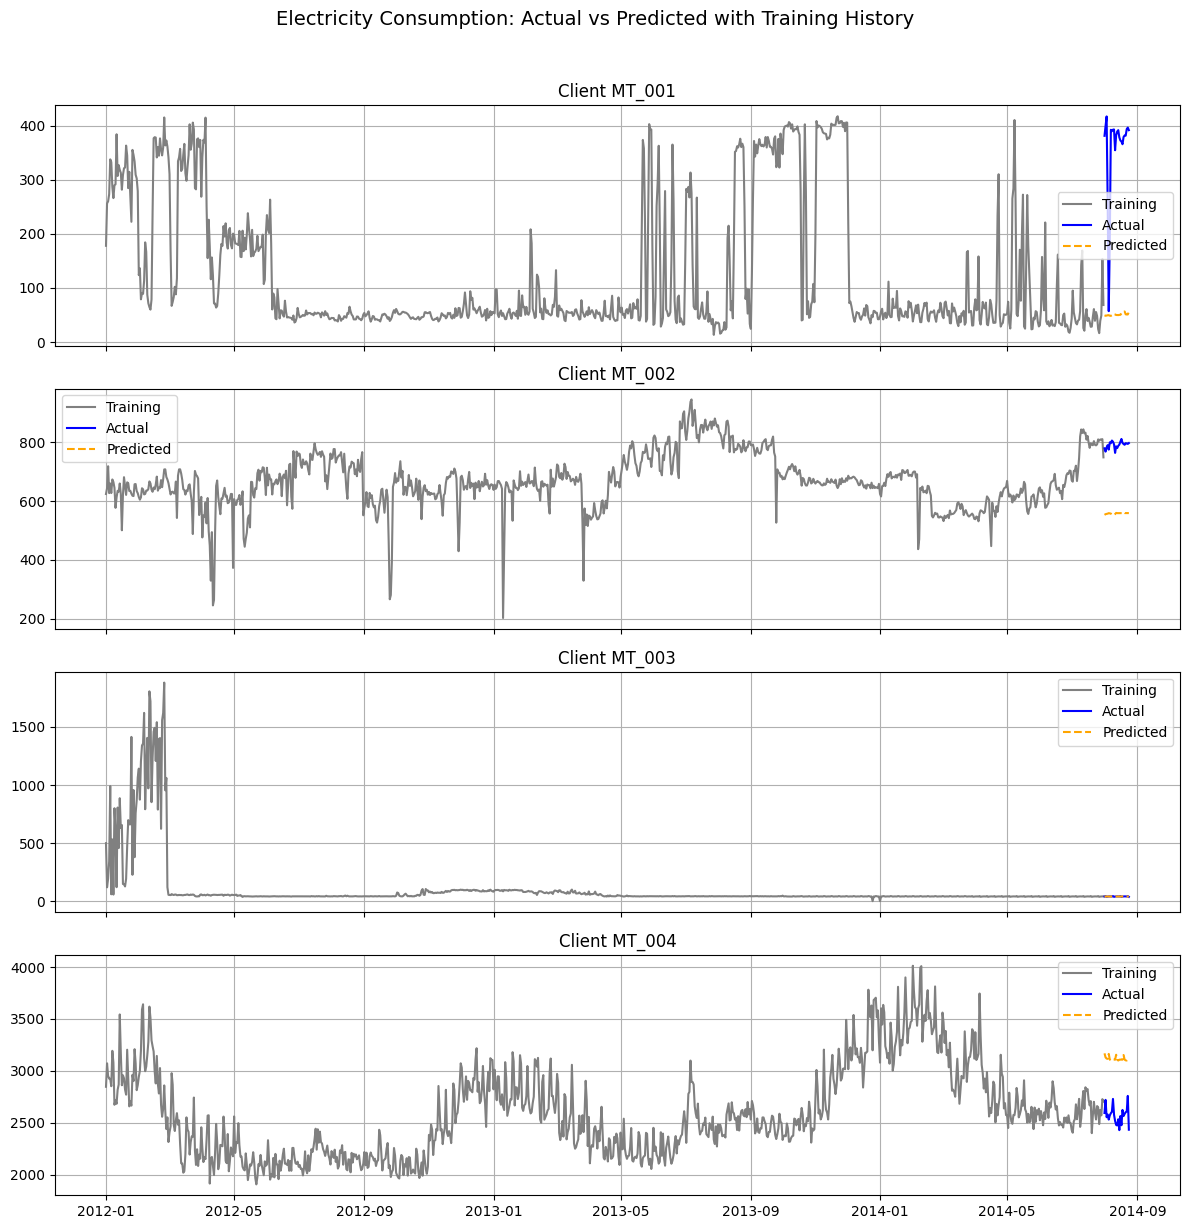

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Convert tensors to numpy
y_pred_np = y_pred_final.detach().cpu().numpy()
y_true_np = y_true.detach().cpu().numpy()

# Match client ID order
client_ids = list(series_dict_test.keys())
prediction_length = y_pred_np.shape[1]

# Select a few clients to plot
selected_clients = client_ids[:4]  # change this to other IDs if needed

# Plot
fig, axes = plt.subplots(len(selected_clients), 1, figsize=(12, 12), sharex=True)
fig.suptitle("Electricity Consumption: Actual vs Predicted with Training History", fontsize=14, y=1.02)

for i, client_id in enumerate(selected_clients):
    client_index = client_ids.index(client_id)

    # Get training and test series (pandas Series with DatetimeIndex)
    train_series = series_dict_train[client_id]
    test_series = series_dict_test[client_id]

    # Forecast values and corresponding dates
    forecast_dates = pd.date_range(start=test_series.index[0], periods=prediction_length, freq='D')
    y_pred = y_pred_np[client_index]
    y_true = y_true_np[client_index]

    # Plot
    axes[i].plot(train_series.index, train_series.values, label="Training", color="gray")
    axes[i].plot(test_series.index[:prediction_length], y_true, label="Actual", color="blue")
    axes[i].plot(test_series.index[:prediction_length], y_pred, label="Predicted", linestyle='--', color="orange")
    axes[i].set_title(f"Client {client_id}")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()
